In [1]:
import pyro
import torch
import wandb
import os

import numpy as np

from pyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, init_to_mean
from inference.bayesian.models import TorchModel, BayesianModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "spain",
            "model_widths": [512, 1],
            "activation": "relu",
            "distributions": ["unif", "unif", "gauss"],
            "parameters": [[0,1],[0,1]],
            "dim_reduction": False,
            "low_rank": True,
            "num_samples": 8000,
            "inference": "svi",
            "lr": 0.0126,
            "num_iterations": 2000,
            "plot": True,
            "sweep": True
            }

os.environ["WANDB_MODE"]="offline"
os.environ["WANDB_NOTEBOOK_NAME"]="main_svi.ipynb"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [9]:
pyro.set_rng_seed(2)

In [3]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 907, Val: 455, Te: 455


# SVI

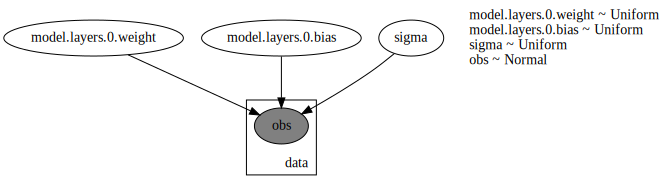

In [4]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
svi_model = BayesianModel(torch_model, config, device)
svi_model.render_model(model_args=(train_embedding[0], Ytr[0]))

Autoguide for testing

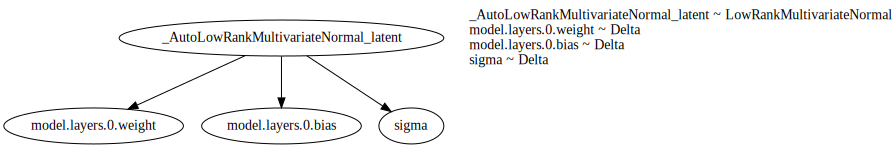

In [5]:
pyro.clear_param_store()

# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoLowRankMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
# A full multivariate normal saturates gpu memory, the covariance matrix is too big
# guide = AutoMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding[0], Ytr[0]), render_distributions=True)

In [6]:
for n, p in pyro.get_param_store().items():
    print(f"{n}, shape: {p.shape}")

AutoMultivariateNormal.loc, shape: torch.Size([514])
AutoMultivariateNormal.scale, shape: torch.Size([514])
AutoMultivariateNormal.scale_tril, shape: torch.Size([514, 514])


In [6]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [7]:
predictive, diagnostics = inference(config, svi_model, guide,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Epoch 2000: 100%|██████████| 2000/2000 [00:39<00:00, 51.23it/s, loss=2.82]


<Figure size 600x600 with 0 Axes>

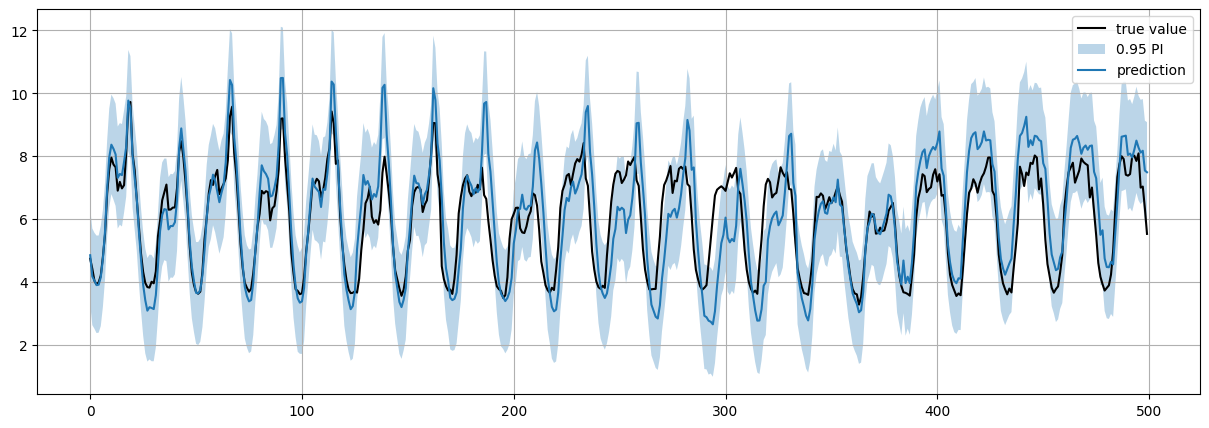

In [8]:
CI = [diagnostics["quantiles"][2], diagnostics["quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "svi", 500)

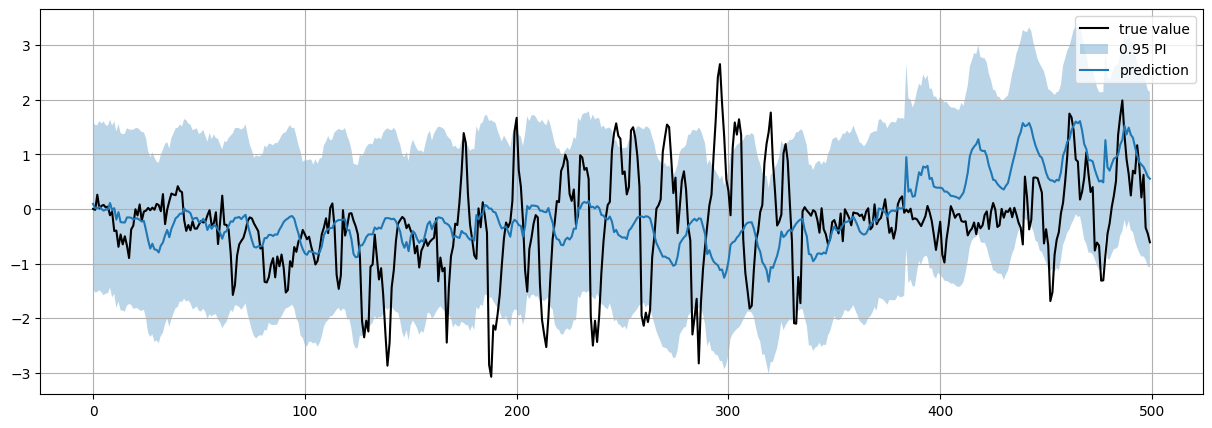

In [9]:
plot_forecast(predictive, torch.concat([torch.zeros(1), Yte[:-1]]), np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), CI, "svi", 500)

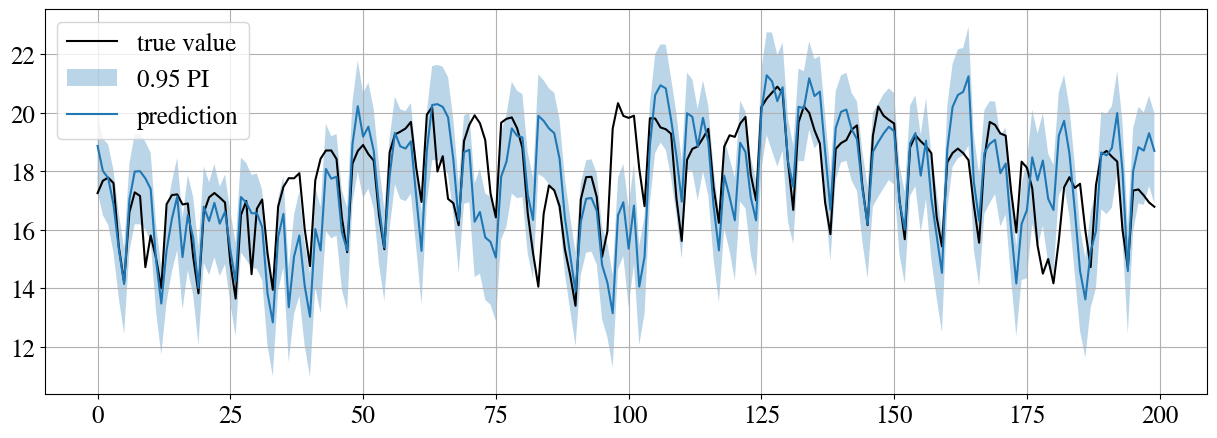

In [8]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "svi")

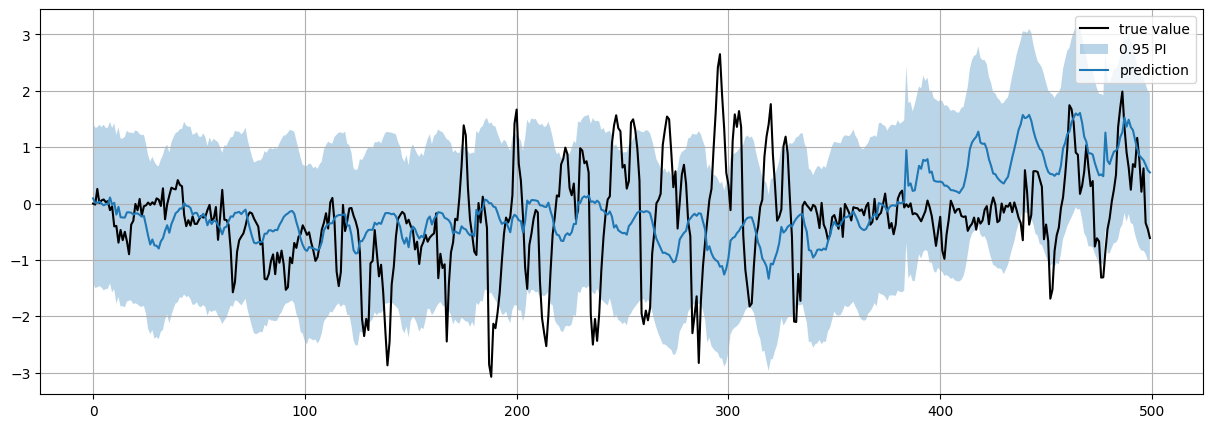

In [11]:
plot_forecast(predictive, torch.concat([torch.zeros(1), Yte[:-1]]), np.zeros_like(diffXte.squeeze()), np.zeros_like(diffYte.squeeze()), CI, "svi", 500)

In [9]:
for k, v in diagnostics.items():
    print(k, "\t", v)

train_time 	 2.5625
final_loss 	 2.82369945672276
inference_time 	 22.359375
cal_error 	 0.6765223463349836
new_cal_error 	 0.0594154751841565
quantiles 	 [0, 0.005, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 0.995]
new_quantiles 	 [0.         0.00379167 0.046875   0.20416667 0.30758929 0.34305556
 0.39114583 0.4263587  0.43872283 0.45113636 0.4640625  0.47682292
 0.48867188 0.50035714 0.50848214 0.51660714 0.52473214 0.53263889
 0.54053819 0.5484375  0.55712891 0.56601563 0.57490234 0.584375
 0.59385417 0.6025641  0.60985577 0.61714744 0.6244391  0.6355
 0.646875   0.65982143 0.

In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')